<a href="https://colab.research.google.com/github/sayyidahbisa/sekarya-machine-learning/blob/main/Sekarya_Model_with_Kflod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="VCMwk7BaHp2QZgOPj6zY")
project = rf.workspace("lf-ggv4a").project("ai-images")
dataset = project.version(6).download("folder")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 803.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstal

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to AI-images-6 in folder:: 100%|██████████| 7713/7713 [00:01<00:00, 4202.41it/s]


In [2]:
dataset_url="/lf-ggv4a/ai-images/dataset/6"
dataset_name="AI-images-6"
!roboflow datasets download -d  {dataset_url}
!mkdir {dataset_name}
!unzip -q {dataset_name}.zip -d {dataset_name}
!rm -f {dataset_name}.zip

usage: roboflow [-h] {login,download,upload,import} ...
roboflow: error: argument {login,download,upload,import}: invalid choice: 'datasets' (choose from 'login', 'download', 'upload', 'import')
mkdir: cannot create directory ‘AI-images-6’: File exists
unzip:  cannot find or open AI-images-6.zip, AI-images-6.zip.zip or AI-images-6.zip.ZIP.


In [3]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [4]:
train_dir = '/content/AI-images-6/train'
val_dir = '/content/AI-images-6/test'

train_ai_dir = os.path.join(train_dir, 'AI')
train_human_dir = os.path.join(train_dir, 'Human')

val_ai_dir = os.path.join(train_dir, 'AI')
val_human_dir = os.path.join(train_dir, 'Human')

print(f"There are {len(os.listdir(train_ai_dir))} images of AI-made art for training.\n")
print(f"There are {len(os.listdir(train_human_dir))} images of human-made art for training.\n")
print(f"There are {len(os.listdir(val_ai_dir))} images of AI-made art for validation.\n")
print(f"There are {len(os.listdir(val_human_dir))} images of human-made art for validation.\n")

There are 2689 images of AI-made art for training.

There are 2702 images of human-made art for training.

There are 2689 images of AI-made art for validation.

There are 2702 images of human-made art for validation.



Sample AI-generated art image:


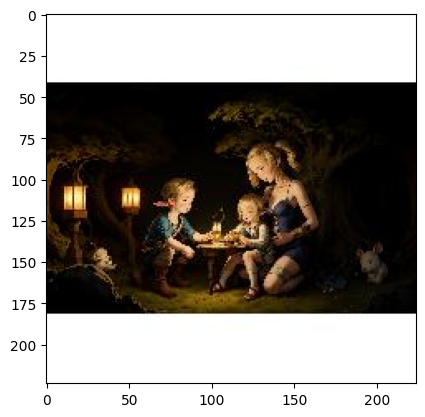


Sample human-made art image:


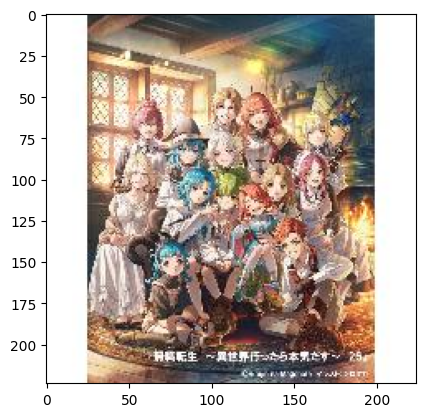

In [5]:
print("Sample AI-generated art image:")
plt.imshow(load_img(f"{os.path.join(train_ai_dir, os.listdir(train_ai_dir)[0])}"))
plt.show()

print("\nSample human-made art image:")
plt.imshow(load_img(f"{os.path.join(train_human_dir, os.listdir(train_human_dir)[0])}"))
plt.show()

In [6]:
sample_image  = load_img(f"{os.path.join(train_ai_dir, os.listdir(train_ai_dir)[0])}")

sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (224, 224, 3)


In [7]:
def train_val_generators(TRAIN_DIR, VAL_DIR):
  train_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(
      directory=TRAIN_DIR,
      batch_size=32,
      class_mode='binary',
      target_size=(224, 224))

  val_datagen = ImageDataGenerator(rescale=1./255)

  val_generator = val_datagen.flow_from_directory(
      directory=VAL_DIR,
      batch_size=32,
      class_mode='binary',
      target_size=(224, 224))

  return train_generator, val_generator

In [8]:
train_generator, val_generator = train_val_generators(train_dir, val_dir)

Found 5391 images belonging to 2 classes.
Found 771 images belonging to 2 classes.


In [9]:
def create_pre_trained_model():
  pre_trained_model = VGG19(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet')

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [10]:
vgg = create_pre_trained_model()
vgg.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [11]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90:
                self.model.stop_training = True

custom_callback = MyCallback()

In [12]:
def create_model(with_vgg=True):
  model = tf.keras.Sequential()

  if with_vgg:
    model.add(vgg)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2)),
  else:
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))

  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(learning_rate=0.0001),
                loss=BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

In [13]:
vgg_model = create_model(with_vgg=True)
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [14]:
vgg_model_history = vgg_model.fit(
    train_generator,
    epochs=10,
    verbose=1,
    callbacks=[custom_callback],
    validation_data=val_generator)

vgg_model.save("vgg-model.h5")

Epoch 1/10
169/169 [==============================] - 46s 189ms/step - loss: 0.5270 - accuracy: 0.7390 - val_loss: 0.4282 - val_accuracy: 0.8093
Epoch 2/10
169/169 [==============================] - 31s 180ms/step - loss: 0.4018 - accuracy: 0.8292 - val_loss: 0.3730 - val_accuracy: 0.8457
Epoch 3/10
169/169 [==============================] - 32s 189ms/step - loss: 0.3564 - accuracy: 0.8525 - val_loss: 0.3473 - val_accuracy: 0.8547
Epoch 4/10
169/169 [==============================] - 34s 199ms/step - loss: 0.3276 - accuracy: 0.8653 - val_loss: 0.3310 - val_accuracy: 0.8664
Epoch 5/10
169/169 [==============================] - 32s 188ms/step - loss: 0.3042 - accuracy: 0.8794 - val_loss: 0.3151 - val_accuracy: 0.8638
Epoch 6/10
169/169 [==============================] - 32s 190ms/step - loss: 0.2863 - accuracy: 0.8874 - val_loss: 0.3150 - val_accuracy: 0.8586
Epoch 7/10
169/169 [==============================] - 33s 197ms/step - loss: 0.2705 - accuracy: 0.8967 - val_loss: 0.2996 - val_ac

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [ ]:
conv_model = create_model(with_vgg=False)
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 93312)             0         
                                                                 
 dense_1 (Dense)             (None, 32)               

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np

In [ ]:
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 32, 32, 3
loss_function = sparse_categorical_crossentropy
no_classes = 100
no_epochs = 25
optimizer = Adam()
verbosity = 1
num_folds = 10

# Load CIFAR-10 data
(input_train, target_train), (input_test, target_test) = cifar10.load_data()

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((train_generator, val_generator), axis=0)
targets = np.concatenate((target_train, target_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits= 5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(no_classes, activation='softmax'))

  # Compile the model
  model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['accuracy'])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

NameError: ignored